# Load Libraries

In [64]:
import os
import warnings
import logging
import sys
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import dotenv
import pyet
from linearmodels.panel import PanelOLS, RandomEffects
from linearmodels.panel import compare

# Load environment variables from .env file
dotenv.load_dotenv()

# Set up logging
logging.basicConfig(level=logging.INFO)

# Suppress warnings
warnings.filterwarnings("ignore")

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)

# Load Data

In [65]:
# Load Data From Pickle
with open('../../data/Data_Iran_ETo_1983_2022.pkl', 'rb') as f:
    data = pickle.load(f)
    logging.info("Data loaded from pickle file.")

INFO:root:Data loaded from pickle file.


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6252652 entries, 0 to 6252651
Data columns (total 36 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   station_id         object        
 2   station_name       object        
 3   region_id          object        
 4   region_name        object        
 5   lat                float64       
 6   lon                float64       
 7   station_elevation  float64       
 8   tmax               float64       
 9   tmin               float64       
 10  tm                 float64       
 11  umax               float64       
 12  umin               float64       
 13  um                 float64       
 14  ffm                float64       
 15  sshn               float64       
 16  rrr24              float64       
 17  Penman             float64       
 18  FAO-56             float64       
 19  Priestley-Taylor   float64       
 20  Kimberly-Penman    float

In [67]:
data[['region_id', 'station_id']].nunique()

region_id      31
station_id    428
dtype: int64

# Cluster Data

In [69]:
# Cluster Stations K-Means
from sklearn.cluster import KMeans
coords = data[['lat', 'lon']].drop_duplicates().reset_index(drop=True)
kmeans = KMeans(n_clusters=5, random_state=42)
coords['cluster'] = kmeans.fit_predict(coords[['lat', 'lon']])
data = data.merge(coords, on=['lat', 'lon'], how='left')
data['cluster'] = data['cluster'].astype('category')
data[['region_id', 'station_id', 'cluster']].drop_duplicates().groupby('region_id').count()
data[['region_id', 'station_id', 'cluster']].drop_duplicates().groupby('cluster').count()
data['cluster'].value_counts().sort_index()


cluster
0    2118305
1     672014
2     891149
3    1212547
4    1358637
Name: count, dtype: int64

# Filter and Prepare Data

In [ ]:
# Filter stations with at least 10 * 365 rows of data of FAO-56 column (group by station_id and region_id)
min_rows = 15 * 365
df = data.groupby(['region_id', 'station_id']).filter(lambda x: x['FAO-56'].count() >= min_rows)
logging.info(f"Filtered valid stations. Remaining stations: {df[['region_id', 'station_id']].nunique()}")
df.info()

INFO:root:Filtered valid stations. Remaining stations: region_id      31
station_id    182
dtype: int64


<class 'pandas.core.frame.DataFrame'>
Index: 2658838 entries, 0 to 6194215
Data columns (total 36 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   station_id         object        
 2   station_name       object        
 3   region_id          object        
 4   region_name        object        
 5   lat                float64       
 6   lon                float64       
 7   station_elevation  float64       
 8   tmax               float64       
 9   tmin               float64       
 10  tm                 float64       
 11  umax               float64       
 12  umin               float64       
 13  um                 float64       
 14  ffm                float64       
 15  sshn               float64       
 16  rrr24              float64       
 17  Penman             float64       
 18  FAO-56             float64       
 19  Priestley-Taylor   float64       
 20  Kimberly-Penman    float64   

In [39]:
df[['region_id', 'station_id']].nunique()

region_id      31
station_id    182
dtype: int64

# Panel Data Model

In [46]:
df_model = df.copy()

# Make sure date is datetime
df_model['date'] = pd.to_datetime(df_model['date'])


# Set multi-index: (station, time)
df_model = df_model.set_index(['station_id', 'date']).sort_index()

# Drop missing values
panel_df = df_model[['FAO-56', 'tmin', 'tmax', 'tm', 'um', 'ffm', 'sshn', 'rrr24', 'Hargreaves', 'lat', 'station_elevation']].dropna()

# Dependent variable
y = panel_df['FAO-56']

# Independent variables (add constant automatically)
X = panel_df[['tm', 'tmin', 'tmax', 'Hargreaves']]
X = X.assign(const=1)

#### Fit Fixed Effects Model

In [47]:
mod = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
fe_res = mod.fit(cov_type='clustered', cluster_entity=True)
print(fe_res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 FAO-56   R-squared:                        0.7991
Estimator:                   PanelOLS   R-squared (Between):              0.5467
No. Observations:             1965162   R-squared (Within):               0.7991
Date:                Mon, Sep 15 2025   R-squared (Overall):              0.7639
Time:                        10:16:51   Log-likelihood                -3.133e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.954e+06
Entities:                         182   P-value                           0.0000
Avg Obs:                     1.08e+04   Distribution:               F(4,1964976)
Min Obs:                       5481.0                                           
Max Obs:                    1.448e+04   F-statistic (robust):             2320.1
                            

### Fit Random Effects Model

In [48]:
re_mod = RandomEffects(y, X)
re_res = re_mod.fit()
print(re_res.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 FAO-56   R-squared:                        0.8021
Estimator:              RandomEffects   R-squared (Between):              0.5712
No. Observations:             2454510   R-squared (Within):               0.8021
Date:                Sun, Sep 14 2025   R-squared (Overall):              0.7643
Time:                        18:08:15   Log-likelihood                -3.916e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   2.487e+06
Entities:                         362   P-value                           0.0000
Avg Obs:                       6780.4   Distribution:               F(4,2454505)
Min Obs:                       1.0000                                           
Max Obs:                    1.448e+04   F-statistic (robust):          2.487e+06
                            

### Choose Between FE and RE

In [49]:
compare({'FE': fe_res, 'RE': re_res})

,FE,RE
Dep. Variable,FAO-56,FAO-56
Estimator,PanelOLS,RandomEffects
No. Observations,2454510,2454510
Cov. Est.,Clustered,Unadjusted
R-squared,0.8021,0.8021
R-Squared (Within),0.8021,0.8021
R-Squared (Between),0.5683,0.5712
R-Squared (Overall),0.7649,0.7643
F-statistic,2.487e+06,2.487e+06
P-value (F-stat),0.0000,0.0000


# Plot Results

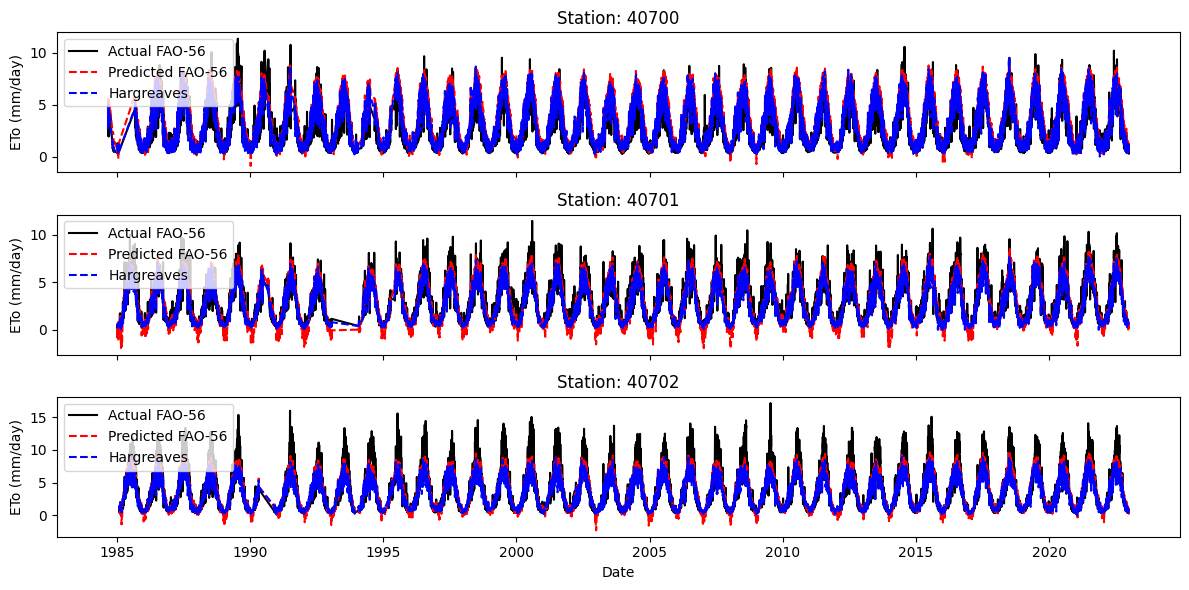

In [49]:
panel_df['FAO56_pred'] = fe_res.predict().fitted_values
stations_to_plot = panel_df.index.get_level_values(0).unique()[:3]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(stations_to_plot), 1, figsize=(12, 6), sharex=True)

for i, station in enumerate(stations_to_plot):
    data_plot = panel_df.xs(station, level='station_id')

    axes[i].plot(data_plot.index, data_plot['FAO-56'], label="Actual FAO-56", color="black")
    axes[i].plot(data_plot.index, data_plot['FAO56_pred'], label="Predicted FAO-56", color="red", linestyle="--")
    axes[i].plot(data_plot.index, data_plot['Hargreaves'], label="Hargreaves", color="blue", linestyle="--")
    axes[i].set_title(f"Station: {station}")
    axes[i].set_ylabel("ETo (mm/day)")
    axes[i].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()

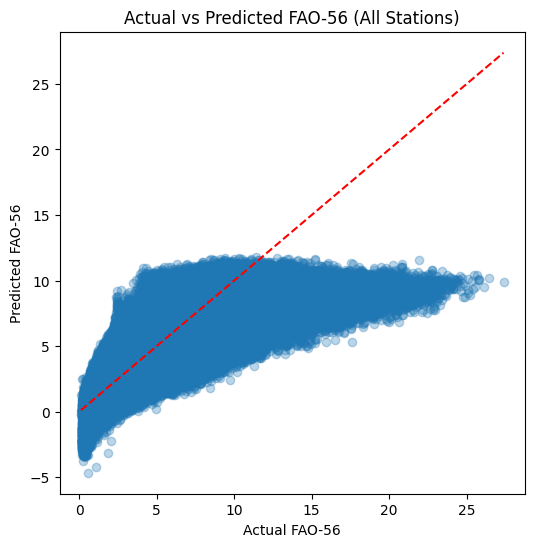

In [51]:
plt.figure(figsize=(6,6))
plt.scatter(panel_df['FAO-56'], panel_df['FAO56_pred'], alpha=0.3)
plt.plot([panel_df['FAO-56'].min(), panel_df['FAO-56'].max()],
         [panel_df['FAO-56'].min(), panel_df['FAO-56'].max()],
         color="red", linestyle="--")
plt.xlabel("Actual FAO-56")
plt.ylabel("Predicted FAO-56")
plt.title("Actual vs Predicted FAO-56 (All Stations)")
plt.show()

# Compare FAO-56 and Hargreaves

In [56]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Create a results DataFrame
station_metrics = []

for station in panel_df.index.get_level_values(0).unique():
    data_F_HS = panel_df.xs(station, level='station_id')

    y_true = data_F_HS['FAO-56']
    y_pred = data_F_HS['Hargreaves']

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    station_metrics.append({
        'station_id': station,
        'R2': r2,
        'RMSE': rmse
    })

station_results = pd.DataFrame(station_metrics).set_index('station_id')


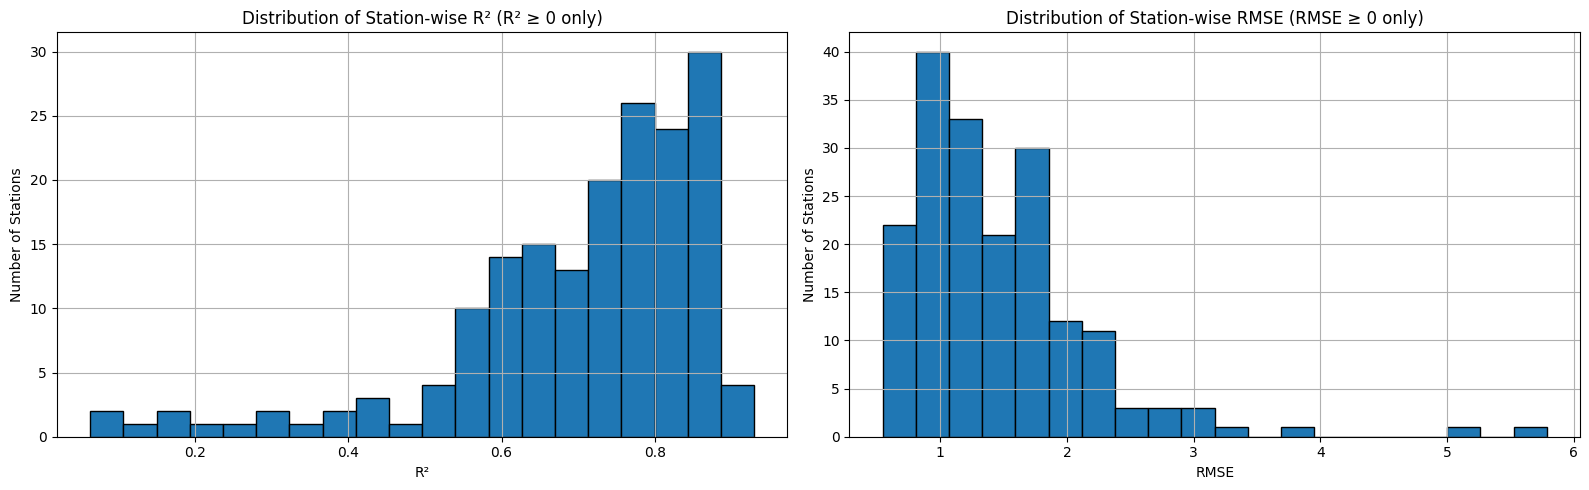

In [57]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# R² histogram
valid_r2 = station_results[station_results['R2'] >= 0]['R2']
valid_r2.hist(bins=20, edgecolor="black", ax=axes[0])
axes[0].set_xlabel("R²")
axes[0].set_ylabel("Number of Stations")
axes[0].set_title("Distribution of Station-wise R² (R² ≥ 0 only)")

# RMSE histogram
valid_rmse = station_results[station_results['RMSE'] >= 0]['RMSE']
valid_rmse.hist(bins=20, edgecolor="black", ax=axes[1])
axes[1].set_xlabel("RMSE")
axes[1].set_ylabel("Number of Stations")
axes[1].set_title("Distribution of Station-wise RMSE (RMSE ≥ 0 only)")

plt.tight_layout()
plt.show()

# # Compare FAO-56 and PD Model

In [58]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Create a results DataFrame
station_metrics = []

for station in panel_df.index.get_level_values(0).unique():
    data_F_PD = panel_df.xs(station, level='station_id')

    y_true = data_F_PD['FAO-56']
    y_pred = data_F_PD['FAO56_pred']

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    station_metrics.append({
        'station_id': station,
        'R2': r2,
        'RMSE': rmse
    })

station_results = pd.DataFrame(station_metrics).set_index('station_id')


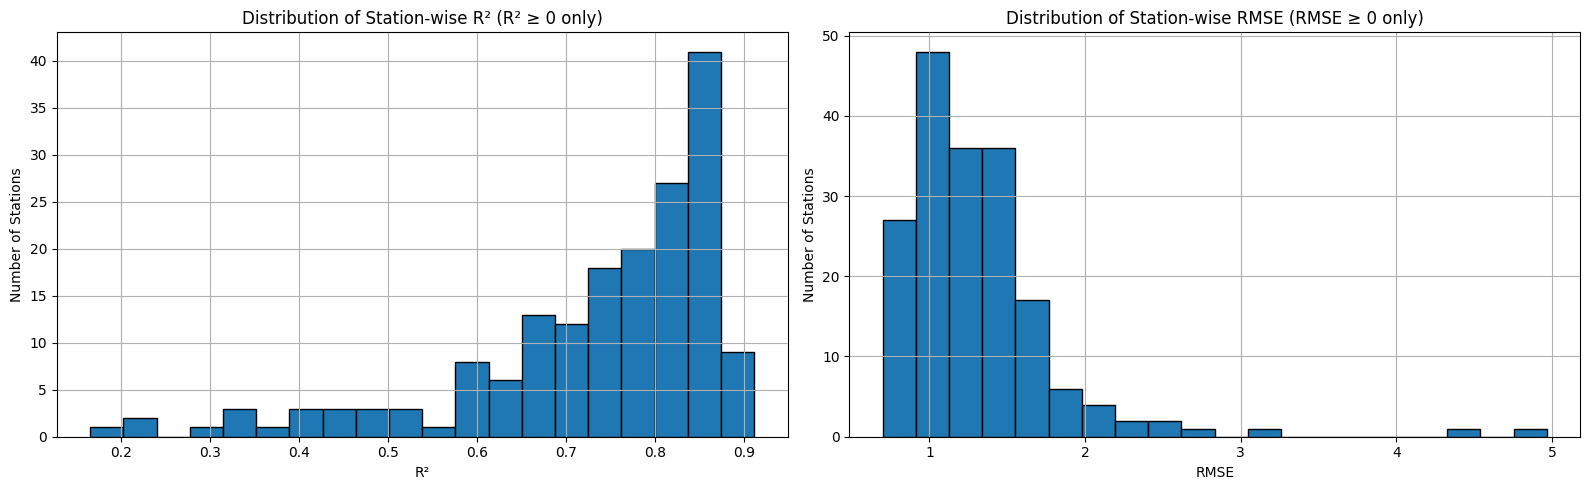

In [59]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# R² histogram
valid_r2 = station_results[station_results['R2'] >= 0]['R2']
valid_r2.hist(bins=20, edgecolor="black", ax=axes[0])
axes[0].set_xlabel("R²")
axes[0].set_ylabel("Number of Stations")
axes[0].set_title("Distribution of Station-wise R² (R² ≥ 0 only)")

# RMSE histogram
valid_rmse = station_results[station_results['RMSE'] >= 0]['RMSE']
valid_rmse.hist(bins=20, edgecolor="black", ax=axes[1])
axes[1].set_xlabel("RMSE")
axes[1].set_ylabel("Number of Stations")
axes[1].set_title("Distribution of Station-wise RMSE (RMSE ≥ 0 only)")

plt.tight_layout()
plt.show()

# Plot FAO-56 and PD Model and Hargreaves for Selected Stations

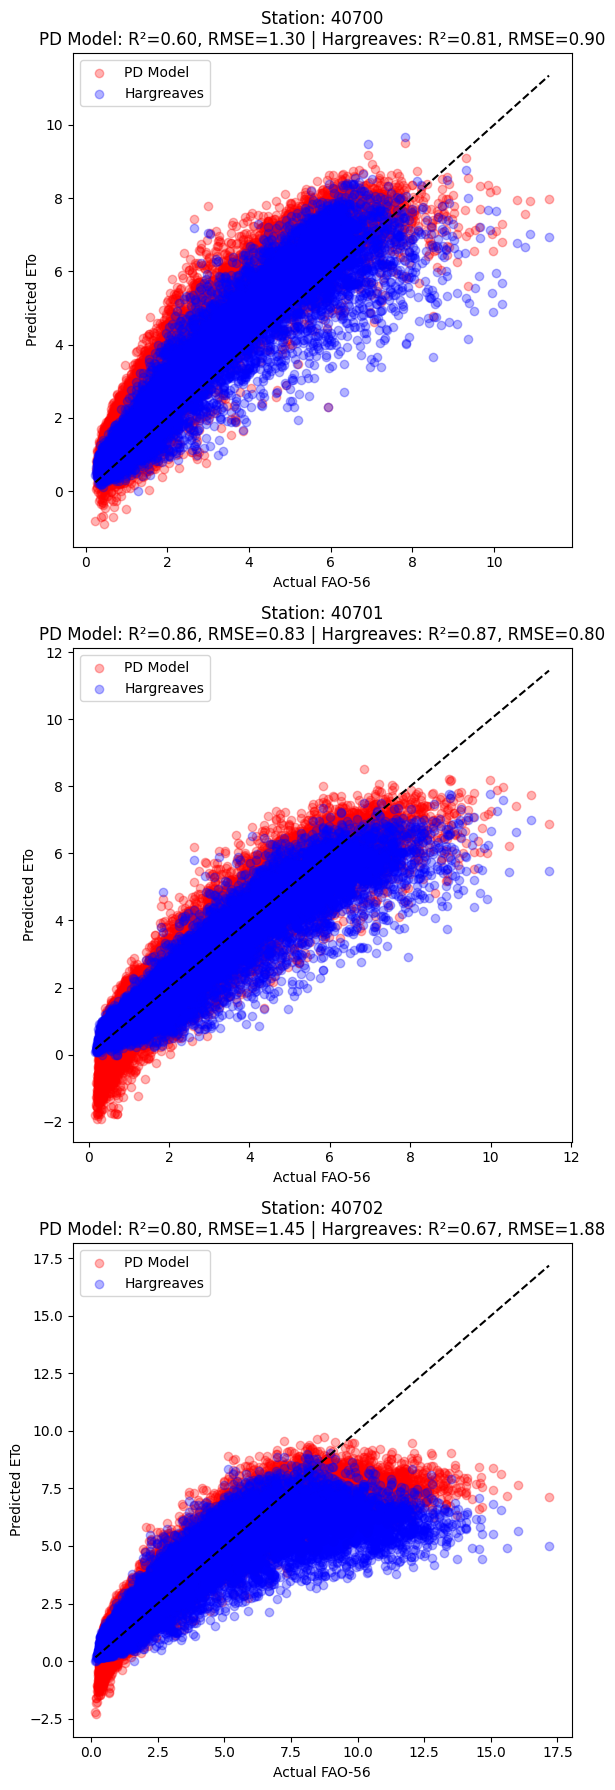

In [62]:
# Plot FAO-56 and PD Model and Hargreaves for Selected Stations (scatter plot)
# Show RMSE and R² in the title
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(stations_to_plot), 1, figsize=(6, 6*len(stations_to_plot)))
for i, station in enumerate(stations_to_plot):
    data_plot = panel_df.xs(station, level='station_id')

    axes[i].scatter(data_plot['FAO-56'], data_plot['FAO56_pred'], alpha=0.3, label="PD Model", color="red")
    axes[i].scatter(data_plot['FAO-56'], data_plot['Hargreaves'], alpha=0.3, label="Hargreaves", color="blue")
    axes[i].plot([data_plot['FAO-56'].min(), data_plot['FAO-56'].max()],
                 [data_plot['FAO-56'].min(), data_plot['FAO-56'].max()],
                 color="black", linestyle="--")
    axes[i].set_title(f"Station: {station}")
    axes[i].set_xlabel("Actual FAO-56")
    axes[i].set_ylabel("Predicted ETo")
    axes[i].legend()
    # Get RMSE and R²
    r2_pd = r2_score(data_plot['FAO-56'], data_plot['FAO56_pred'])
    rmse_pd = np.sqrt(mean_squared_error(data_plot['FAO-56'], data_plot['FAO56_pred']))
    r2_hs = r2_score(data_plot['FAO-56'], data_plot['Hargreaves'])
    rmse_hs = np.sqrt(mean_squared_error(data_plot['FAO-56'], data_plot['Hargreaves']))
    axes[i].set_title(f"Station: {station}\nPD Model: R²={r2_pd:.2f}, RMSE={rmse_pd:.2f} | Hargreaves: R²={r2_hs:.2f}, RMSE={rmse_hs:.2f}") 
plt.tight_layout()
plt.show()  
